# Example for validating VAE
We'll be using the following:
- 99 image testing batch
- feature_extraction function from pvimage (https://github.com/cwru-sdle/pvimage)
- t-test to see if the features are similar between original/VAE recreated
- plot of latent space with k-means clustering to identify if features are clustered

In [1]:
import sys
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from custom_dataset import CustomDataset
from termcolor import colored
# from pytorch_ssim import SSIM #don't use pip installed version, is not maintained
from torchvision import transforms
import cv2
from VAE_functions import encode_image, decode_latent_vector, generate_random_images, show_generated_images 
from pathlib import Path
import os

In [2]:
#GPU or CPU
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

True


In [3]:
from VAE_model import Encoder, Decoder, VAE
#load actual model
# model = torch.load('model_slurm2.pth')
model = torch.load('model_newimg_upepochs_3.pth')
model.to(device)

VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (7): ReLU()
      (8): Conv2d(256, 512, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (9): ReLU()
      (10): Conv2d(512, 1024, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (11): ReLU()
    )
    (fc_mu): Linear(in_features=50176, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=50176, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=50, out_features=50176, bias=True)
    (deconv): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
   

In [4]:
# #Load images for testing (old), only duramat-hub images
# pathimages = '/home/nrjost/DuramatCrackImg/'
# df = pd.read_csv(pathimages + 'image_inventory.csv', index_col=[0])

# #Preprocess data as a float 0. to 1.
# def preprocess(impath):
#     dat=io.imread(impath)
#     dat=dat[:,:,:2]/255
#     # dat=dat[:100,:100,:] #testing if cropping the image works
#     # dat = resize(dat, [160, 160])#, anti_aliasing=True) #resize from 400x400 to 100x100
#     return dat.astype('float32')
    
# #All images with cracks
# array=[]
# for i in range(len(df)):
#     if df['has_cracks'].iloc[i]:
#         array.append(preprocess(pathimages + df['maskpaths'].iloc[i]))

# array=np.stack(array)
# print("Size of array with cracked images %s" % str(array.shape))

# # plt.imshow(array[0][:,:,0])
# # plt.imshow(array[0][:,:,1])

# # train=array[:600,:,:,1:2] #second layer contains crack data
# testa=array[600:,:,:,1:2]
# test = CustomDataset(testa)

In [5]:
#load testing batch from new images crack mask using retrained pvvision 
new_pathimages = '/home/nrjost/DuramatCrackImg/emma_pvvision_crack_images/'
root = Path(new_pathimages)
files = os.listdir(root)
files_img = [x for x in files if x.endswith(('tiff'))]
array_new=[]
for i in range(len(files_img)):
    dat=io.imread(f"{root}/{files_img[i]}")
    # dat=dat[:,:,:2]/255
    # dat=dat[:,:,:2]/dat[:,:,1].max
    datmean = dat.mean()
    dat = (dat > datmean).astype(np.float32)
    # dat = dat.astype('float32')
    array_new.append(dat)
array_new = np.stack(array_new)
print("Size of new array with cracked images %s" % str(array_new.shape))

#add new images to training array
# train =  np.concatenate((train, array_new[:,:,:,1:2]), axis = 0)
train = array_new[:-100,:,:,1:2]
testimg = array_new[-99:,:,:,1:2]
test = CustomDataset(testimg)
test_loader = DataLoader(test, batch_size=99, shuffle=True, num_workers=1)


Size of new array with cracked images (1188, 400, 400, 4)


In [6]:
from pvimage import features

In [7]:
#Run modified feature extraction function on all original testing images
# old_pathimages = '/home/nrjost/DuramatCrackImg/'

# dfinfo = pd.read_csv(old_pathimages + 'image_inventory.csv', index_col=[0])
# testimgsreal = array[600:,:,:,1:2]  #to see where they come from check out Cell: "#Load images for testing"

dfinfo = pd.DataFrame()
dfinfo['impath'] = files_img[-99:]
# dfinfo['sa_number'] = 19980
# dfinfo['impath'] = dfinfo['sa_number'].astype('str') + dfinfo['impath']

dffeaturesreal = features.feature_extraction_crack_mask(testimg, dfinfo)

dffeaturesreal.head()

/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimag

,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,327,3,106.727922,0.901097,547,512,1.477404
0,357,4,107.355339,-0.71392,684,566,-0.870552
0,357,0,104.426407,-0.872723,653,572,-0.946429
0,1164,6,483.019336,-1.849976,5943,3050,-1.11543
0,1164,5,366.568542,4.103142,3174,2070,1.467221


In [8]:
#same on output images
model.eval

# Get the VAE outputs for the input images
# for batch in test_loader:
#     batch = torch.tensor(batch)
#     with torch.no_grad():
#         # vae_outputs, _, _ = model(batch)
#         mu, logvar = Encoder(batch)
#         vae_outputs = Decoder(mu)
image_tensors = []
for image in testimg:
    image_tensor = transforms.ToTensor()(image).to(device)
    image_tensors.append(image_tensor)

testtensors = torch.stack(image_tensors)
vae_outputs, _, _ = model(testtensors)


# dfinfo = pd.read_csv(pathimages + 'image_inventory.csv', index_col=[0])
# testimgs = vae_outputs.cpu().squeeze(0).numpy()
testimgs = vae_outputs.cpu().squeeze(0).detach().numpy()
testimg_reshaped = np.reshape(testimgs, (99, 400, 400, 1))

dffeaturesout = features.feature_extraction_crack_mask(testimg_reshaped, dfinfo)

dffeaturesout.head()

torch.Size([99, 1024, 7, 7])


,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,26,14,1045.428499,0.798564,12560,9657,1.349619
0,26,7,952.268073,0.462613,11512,7691,1.407569
0,26,0,629.764502,-2.217181,7628,4582,-1.457899
0,26,2,575.509668,0.071621,5470,3778,1.528178
0,26,13,450.166522,0.131223,4500,3324,0.221914


In [9]:
# violinplot defs

def violinplt(data, palette=None, figsize=(5,4)):
    import seaborn as sns
    fig, ax = plt.subplots(figsize=figsize)
    vp = sns.violinplot(data, widths=2,
                       showmeans=True, showmedians=False, showextrema=False, palette=palette)
    #for palettes check https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette
    means = data.mean().values
    nobs = [str(x) for x in means.round(2).tolist()]
    nobs = ["" + i for i in nobs]
    pos = range(len(nobs))
    if len(pos) > 3:
        for tick, label in zip(pos, ax.get_xticklabels()):
            t = ax.text(pos[tick], means[tick] + 0.03, nobs[tick],
                    horizontalalignment='center',
                    size=10,
                    color='black', backgroundcolor = 'white',
                    weight='semibold')
            t.set_bbox(dict(facecolor='white', alpha=0.5))
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    else:
        for tick, label in zip(pos, ax.get_xticklabels()):
           ax.text(pos[tick], means[tick] + 0.03, nobs[tick],
                    horizontalalignment='center',
                    size=12,
                    color='w',
                    weight='semibold')
    return fig

In [10]:
#Count features in one cell
dffeaturesreal['count_features'] = dffeaturesreal.groupby('cell_number')['cell_number'].transform('count')
dffeaturesrealcount = dffeaturesreal.sort_values(by='cell_number').drop_duplicates('cell_number', keep='first')
dffeaturesout['count_features'] = dffeaturesout.groupby('cell_number')['cell_number'].transform('count')
dffeaturesoutcount = dffeaturesout.sort_values(by='cell_number').drop_duplicates('cell_number', keep='first')

In [11]:
dffeaturesrealcount.reset_index(drop=True, inplace=True)
dffeaturesoutcount.reset_index(drop=True, inplace=True)
featurescounted = pd.concat([dffeaturesoutcount['count_features'], dffeaturesrealcount['count_features']], axis=1, ignore_index=True)
featurescounted.columns = ['Replicated', 'Original']
featurescounted.head()

,Replicated,Original
0,7,3.0
1,7,3.0
2,6,1.0
3,1,1.0
4,2,6.0


/tmp/ipykernel_3900511/1661615342.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffeaturesall_norm[columnstonormalize] = scaler.fit_transform(dffeaturesall_norm)


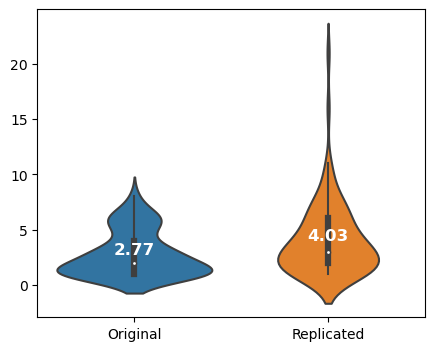

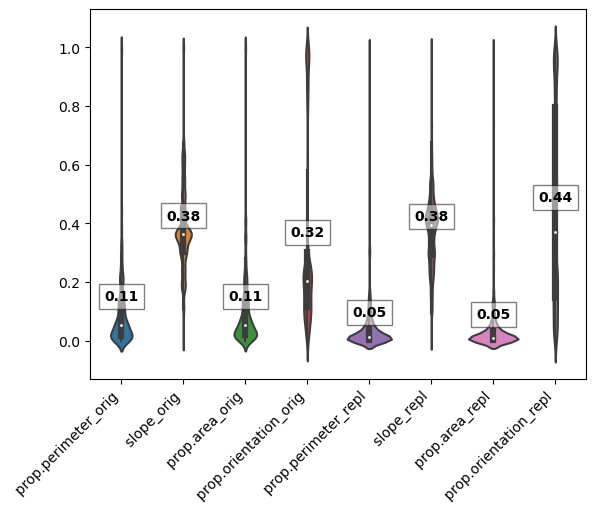

In [12]:
from sklearn.preprocessing import MinMaxScaler


dffeaturesall = dffeaturesreal.merge(dffeaturesout, left_index=True, right_index=True ,suffixes=('_orig', '_repl'),)



# violinplot:
# vp0 = violinplt(dffeaturesout[[' prop.perimeter', ' slope', ' prop.area',
#        ' prop.orientation']])
# vp01 = violinplt(dffeaturesout[[' prop.perimeter', ' slope', ' prop.area',
#        ' prop.orientation']])
vp = violinplt(featurescounted[['Original', 'Replicated']], figsize=(5,4))

scaler=MinMaxScaler()
columnstonormalize = [' prop.perimeter_orig', ' slope_orig',
       ' prop.area_orig', ' prop.orientation_orig',
       ' prop.perimeter_repl', ' slope_repl',
       ' prop.area_repl', ' prop.orientation_repl']
dffeaturesall_norm= dffeaturesall[columnstonormalize]
dffeaturesall_norm[columnstonormalize] = scaler.fit_transform(dffeaturesall_norm)
fig = violinplt(dffeaturesall_norm[[' prop.perimeter_orig', ' slope_orig',
       ' prop.area_orig', ' prop.orientation_orig',
       ' prop.perimeter_repl', ' slope_repl',
       ' prop.area_repl', ' prop.orientation_repl']], figsize=None)
fig.savefig('violins.png', bbox_inches='tight')

### Feature extraction parameters for recreated by VAE seem similar to original images.
### Let's do a t-test to be sure they are similar.

In [13]:
#T-test
from scipy.stats import ttest_ind
#Run directly on original and replicated images and arrays
# # Flatten the images for each group
original_images_flat = testimgs.reshape(testimgs.shape[0], -1)
replicated_images_flat = testimg_reshaped.reshape(vae_outputs.shape[0], -1)

# Initialize arrays to store t-statistics and p-values for each feature
t_stats = np.zeros(original_images_flat.shape[1])
p_values = np.zeros(original_images_flat.shape[1])

# Perform independent two-sample t-test for each feature
for i in range(original_images_flat.shape[1]):
    t_stats[i], p_values[i] = ttest_ind(original_images_flat[:, i], replicated_images_flat[:, i])

# Average the p-values over features (you might want to use other statistics)
average_p_value = np.mean(p_values)

# Output the results
print(f'Avg T-statistic: {np.mean(t_stats)}')
print(f'Avg P-value: {average_p_value}')

# Interpret the results
alpha = 0.05  # Set your significance level
if average_p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference.")

#Run on detected features from the dataframe
columns_of_interest = [' prop.perimeter', ' slope', ' prop.convex_area', ' prop.area',
       ' prop.orientation']

# Extract the data from the dataframes
data1 = dffeaturesreal[columns_of_interest].values.astype(np.float32)
data2 = dffeaturesout[columns_of_interest].values.astype(np.float32)

# Perform independent two-sample t-test for each column
t_stats = []
p_values = []

for col in range(data1.shape[1]):
    t_stat, p_value = ttest_ind(data1[:, col], data2[:, col])
    t_stats.append(t_stat)
    p_values.append(p_value)

# Display results
for col, t_stat, p_value in zip(columns_of_interest, t_stats, p_values):
    print(f"Column: {col}, t-statistic: {t_stat}, p-value: {p_value}")

Avg T-statistic: 0.0
Avg P-value: 1.0
Fail to reject the null hypothesis: There is no significant difference.
Column:  prop.perimeter, t-statistic: -3.546894658948549, p-value: 0.00042357169753385845
Column:  slope, t-statistic: -5.469250528913652, p-value: 6.910316248973158e-08
Column:  prop.convex_area, t-statistic: -3.4477497907260846, p-value: 0.0006091912004021776
Column:  prop.area, t-statistic: -3.5903580642253177, p-value: 0.0003602134412774981
Column:  prop.orientation, t-statistic: -3.9132158907215473, p-value: 0.00010266614689653829


### T-test looks good, there is no segnificant difference.
### Let's look at the latent space to see if different features are separated in clusters.

In [14]:
#Plot latent space
num_images=99
test_loader = DataLoader(test, batch_size=num_images, shuffle=True,num_workers=4)

latent_dim = 50
autoencoder = VAE(latent_dim).to(device)

Linear(in_features=50176, out_features=50, bias=True)
Linear(in_features=50176, out_features=50, bias=True)


Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.S

/home/nrjost/.conda/envs/pyhpc1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/nrjost/.conda/envs/pyhpc1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


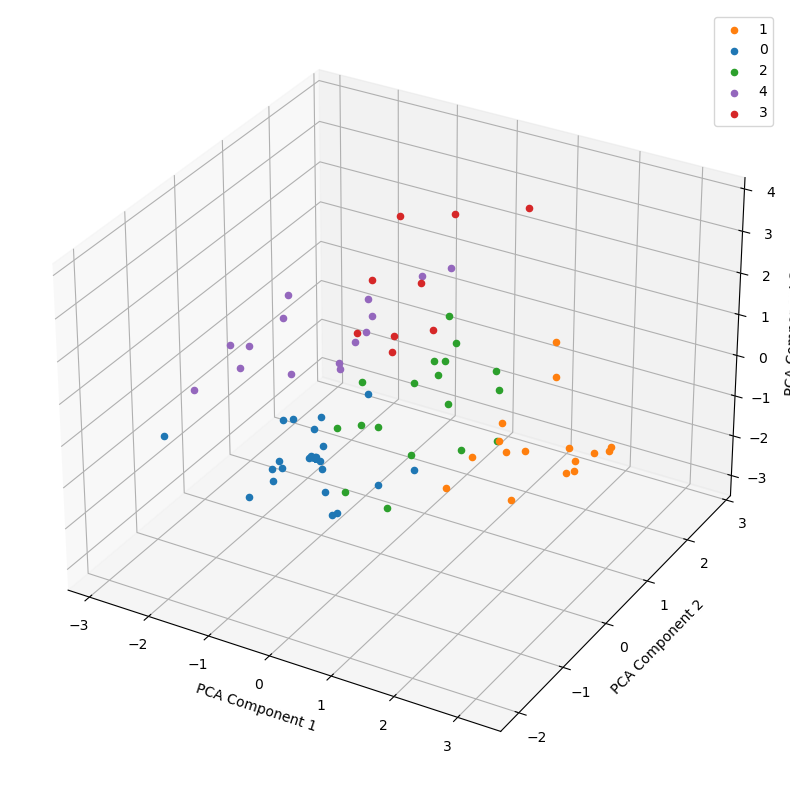

In [15]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import pickle
import os.path

# all_z = np.concatenate([z for z in test_loader], axis = 0)
model.eval()

for i, x in enumerate(test_loader):
    z, y = model.encoder(x.to(device))

input_data = x
# batch_size = 262
# input_data = torch.randn(batch_size, 1, 400, 400)

with torch.no_grad():
    latent_spaces, _ = model.encoder(input_data.cuda()) #this would be x from test_loader

data_reshape = latent_spaces.squeeze().cpu().numpy()

pca = PCA(n_components=3)

#generate data_reduce or load to save time
data_reduced = pca.fit_transform(data_reshape)
with open('PCAdata.pickle', 'wb') as handle:
    pickle.dump(data_reduced, handle, protocol=pickle.HIGHEST_PROTOCOL)

if os.path.isfile('./PCAdata.pickle'):
    with open('PCAdata.pickle', 'rb') as handle:
        data_reduced = pickle.load(handle)

kmean = KMeans(n_clusters=5)
kmeans = kmean.fit(data_reduced)

#generate klabels or load them to svae time
klabels = kmean.fit_predict(data_reduced)
with open('Kmeandata.pickle', 'wb') as handle:
    pickle.dump(klabels, handle, protocol=pickle.HIGHEST_PROTOCOL)

# if os.path.isfile('./Kmeandata.pickle'):
    # with open('Kmeandata.pickle', 'rb') as handle:
        # klabels = pickle.load(handle)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(data_reduced.shape[0]):
    ax.scatter(data_reduced[i, 0], data_reduced[i, 1], data_reduced[i, 2], c=f'C{klabels[i]}', marker='o', label=klabels[i])

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels
unique_labels = {}

# Iterate through handles and labels
for handle, label in zip(handles, labels):
    # Use only the first occurrence of each label
    if label not in unique_labels:
        unique_labels[label] = handle

# Create a legend with unique labels
ax.legend(unique_labels.values(), unique_labels.keys())

# fig.savefig('3Dlatentspace.png')

### Latent space looks how it should.
### Let's plot images from each cluster to see if they are similar

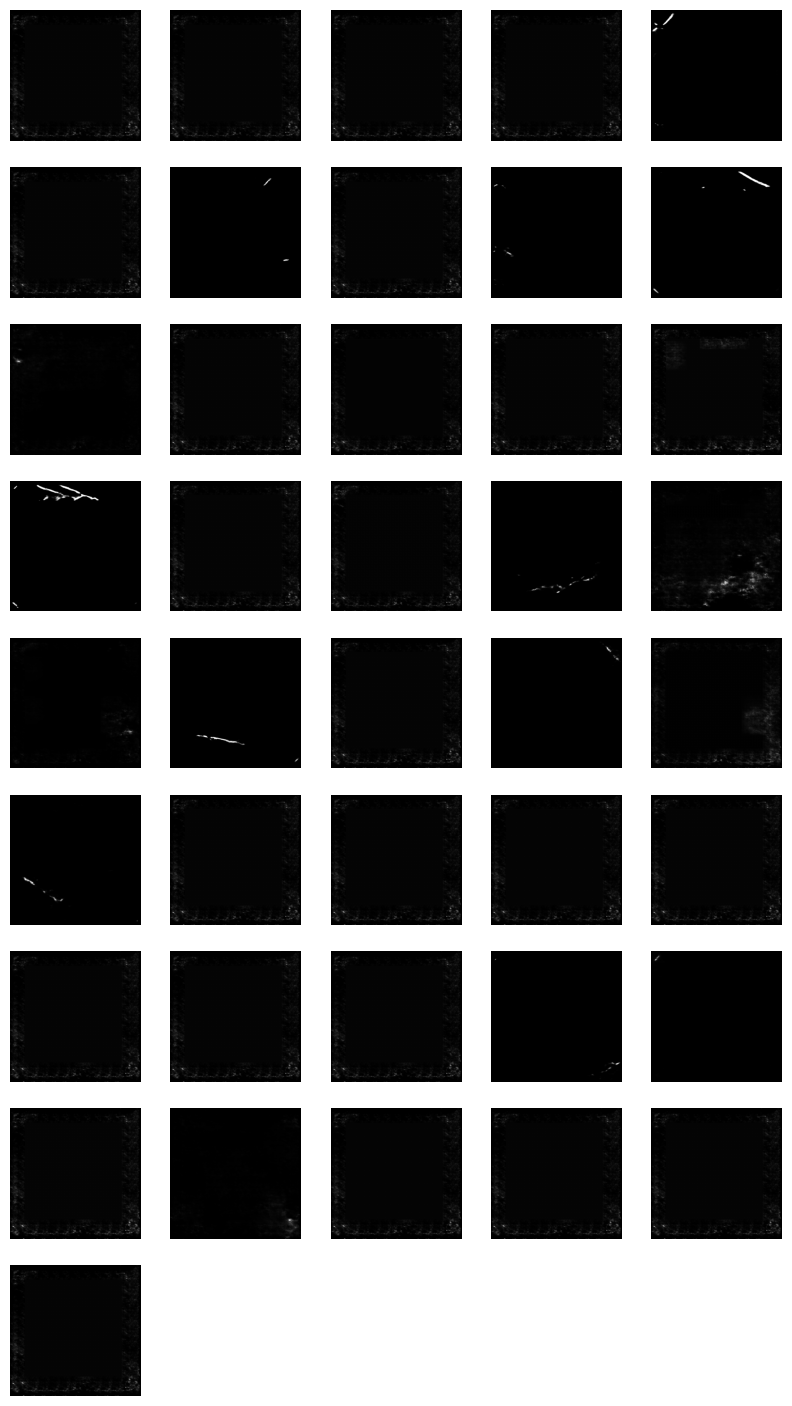

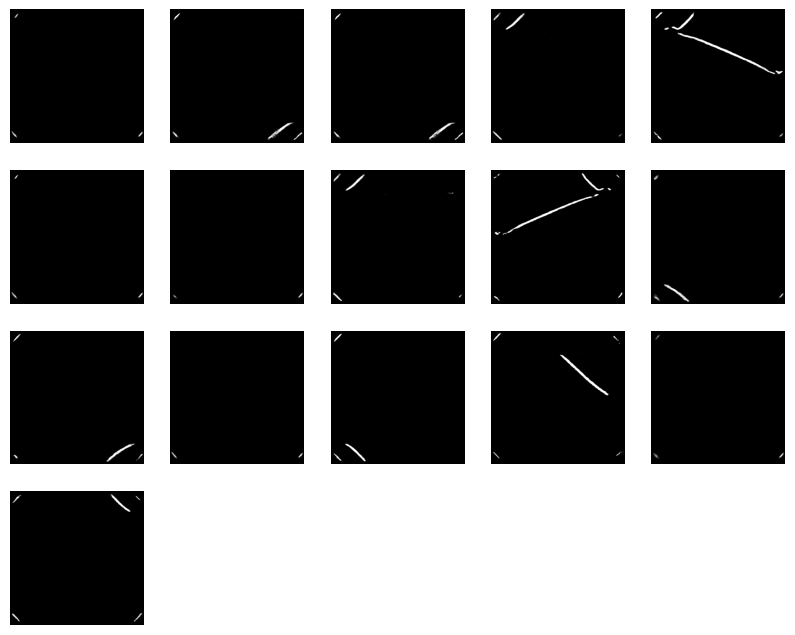

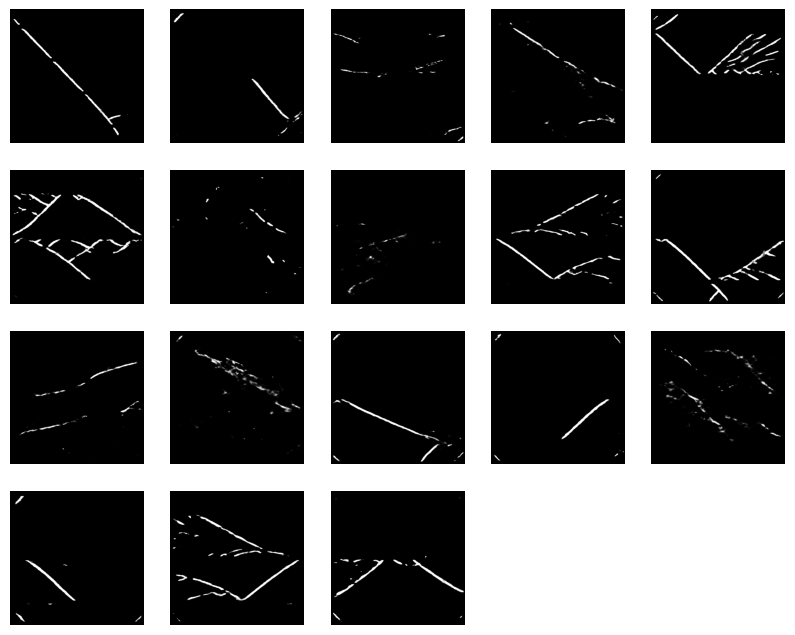

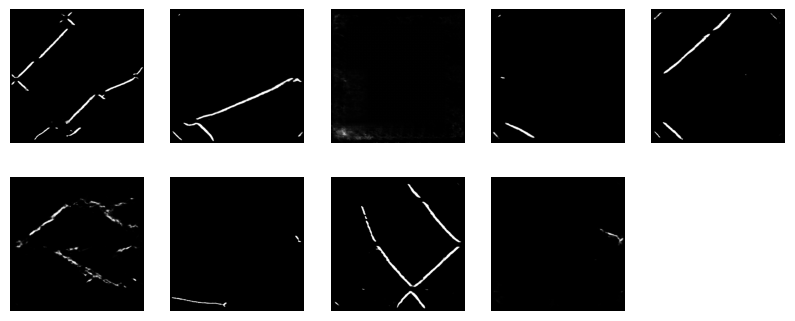

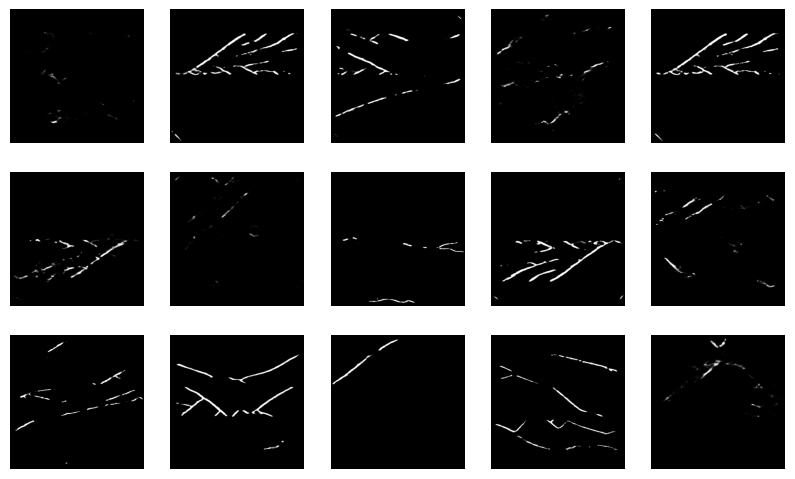

In [16]:
import os
path = os.getcwd()
def show_cluster_images(data, label, path, device):
    nspace = data.query('k_label == '+str(label)+'')
    nspace_vectors = nspace['latent_vectors'].tolist()
    nspace_tensors = torch.tensor(nspace_vectors).to(device)
    generated_images = model.decoder(nspace_tensors)
    fig = show_generated_images(generated_images, len(generated_images), path)
    return fig, generated_images, nspace_vectors
    

#Generate images of latent vectors for each cluster to see whats up with them
lspace = pd.DataFrame({'latent_vectors' : data_reshape.tolist(), 'k_label' : klabels})

#sort for each label and geenrate images
fig, cluster0images, cluster0vectors = show_cluster_images(lspace, 0, path, device)
fig2, cluster1images, cluster1vectors = show_cluster_images(lspace, 1, path, device)
fig3, cluster2images, cluster2vectors = show_cluster_images(lspace, 2, path, device)
fig4, cluster3images, cluster3vectors = show_cluster_images(lspace, 3, path, device)
fig5, cluster4images, cluster4vectors = show_cluster_images(lspace, 4, path, device)
# fig6, cluster0images = show_cluster_images(lspace, 5, device)
# fig7, cluster1images = show_cluster_images(lspace, 6, device)
# fig8, cluster2images = show_cluster_images(lspace, 7, device)
# fig9, cluster3images = show_cluster_images(lspace, 8, device)
# fig10, cluster4images = show_cluster_images(lspace, 9, device)


### Looks like our VAE is working properly and sorting the images in different clusters